In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')

if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
from __future__ import print_function, division

from collections import Counter, OrderedDict

import hosts
import targeting
import mmthecto
import numpy as np

from astropy import units as u
from astropy.coordinates import *
from astropy import table
from astropy.visualization import hist as ahist

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (16, 10)

# Choose hosts and Load stuff

In [4]:
hostlst = hosts.get_saga_hosts_from_google() #'named' hosts

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [5]:
hosts_to_target = [h for h in hostlst if h.name == 'Gilgamesh']
assert len(hosts_to_target)==1
for nsanum in (163136, 161174, 165536, 137625, 140301, 94217):
    hosts_to_target.append(hosts.NSAHost(nsanum))
hosts_to_target

[<hosts.NSAHost object w/ name 'Gilgamesh' AKA: ['NGC5962', 'NSA166313']>,
 <hosts.NSAHost object w/ name 'NSA163136'>,
 <hosts.NSAHost object w/ name 'NSA161174'>,
 <hosts.NSAHost object w/ name 'NSA165536'>,
 <hosts.NSAHost object w/ name 'NSA137625'>,
 <hosts.NSAHost object w/ name 'NSA140301'>,
 <hosts.NSAHost object w/ name 'NSA94217'>]

In [6]:
# now set to the latest base catalogs
for h in hosts_to_target:
    h.fnsdss = 'SAGADropbox/base_catalogs/base_sql_nsa{0}.fits.gz'.format(h.nsaid)
    h._cached_sdss = None

In [7]:
# actually make sure they're loaded here
for h in hosts_to_target:
    h.get_sdss_catalog()
h.get_sdss_catalog().colnames # just to see

['OBJID',
 'RA',
 'DEC',
 'PHOTPTYPE',
 'PHOT_SG',
 'FLAGS',
 'SATURATED',
 'BAD_COUNTS_ERROR',
 'BINNED1',
 'u',
 'g',
 'r',
 'i',
 'z',
 'u_err',
 'g_err',
 'r_err',
 'i_err',
 'z_err',
 'MODELMAGERR_U',
 'MODELMAGERR_G',
 'MODELMAGERR_R',
 'MODELMAGERR_I',
 'MODELMAGERR_Z',
 'EXTINCTION_U',
 'EXTINCTION_G',
 'EXTINCTION_R',
 'EXTINCTION_I',
 'EXTINCTION_Z',
 'DERED_U',
 'DERED_G',
 'DERED_R',
 'DERED_I',
 'DERED_Z',
 'PETRORAD_U',
 'PETRORAD_G',
 'PETRORAD_R',
 'PETRORAD_I',
 'PETRORAD_Z',
 'PETRORADERR_U',
 'PETRORADERR_G',
 'PETRORADERR_R',
 'PETRORADERR_I',
 'PETRORADERR_Z',
 'DEVRAD_U',
 'DEVRADERR_U',
 'DEVRAD_G',
 'DEVRADERR_G',
 'DEVRAD_R',
 'DEVRADERR_R',
 'DEVRAD_I',
 'DEVRADERR_I',
 'DEVRAD_Z',
 'DEVRADERR_Z',
 'DEVAB_U',
 'DEVAB_G',
 'DEVAB_R',
 'DEVAB_I',
 'DEVAB_Z',
 'CMODELMAG_U',
 'CMODELMAGERR_U',
 'CMODELMAG_G',
 'CMODELMAGERR_G',
 'CMODELMAG_R',
 'CMODELMAGERR_R',
 'CMODELMAG_I',
 'CMODELMAGERR_I',
 'CMODELMAG_Z',
 'CMODELMAGERR_Z',
 'PSFMAG_U',
 'PSFMAGERR_U',
 'P

In [8]:
# these are the already-observed objects
spectra = h.load_and_reprocess_sdss_catalog('SAGADropbox/data/saga_spectra_clean_jan15.fits.gz')

In [9]:
# diagnostic just to see how many are in the remove list
for h in hosts_to_target:
    print(h.name, Counter(h.get_sdss_catalog()['REMOVE']))

Gilgamesh Counter({-1: 92844, 3: 6397, 2: 488, 4: 173, 1: 22})
NSA163136 Counter({-1: 81004, 3: 4660, 4: 294, 2: 156, 1: 10})
NSA161174 Counter({-1: 77750, 3: 4945, 4: 303, 2: 92, 1: 6})
NSA165536 Counter({-1: 96670, 3: 5854, 2: 334, 4: 276, 1: 21})
NSA137625 Counter({-1: 66597, 3: 4951, 4: 184, 2: 108, 1: 12})
NSA140301 Counter({-1: 74942, 3: 4678, 2: 284, 4: 260, 1: 8})
NSA94217 Counter({-1: 76012, 3: 3577, 4: 250, 2: 163, 1: 17})


# Generate ranks 

In [10]:
p_column_for_ranking = 'PROBABILITY_CLASS1' #this is *just* SDSS

Note that the ranking scheme *also* functions as the "filtering" step - anything <=0 doesn't get written

In [21]:
rank_descr = {1:'flux star',
              2: '"special" targets',
              3: 'inside Rvir, ML p>10^-3',
              4: 'outside Rvir, ML p>10^-3',
              5: 'inside Rvir, ML p>10^-6, mag/fibermag OK',
              6: 'outside Rvir, ML p>10^-6, mag/fibermag OK',
              7: 'inside Rvir, ML p<10^-6, mag/fibermag OK, colorcut OK',
              8: 'outside Rvir, ML p<10^-6, mag/fibermag OK, colorcut OK',
              0: 'other',
              -10:'SATURATED removed',
              -11:'BAD_COUNTS_ERROR removed',
              -12:'BINNED1 removed'}
rank_descr.update({-100-i:'already observed(zq={})'.format(i) for i in range(5)})
rank_descr.update({-1-i:'removed due to REMOVE={}'.format(i+1) for i in range(9)})

In [12]:
# "special" objects that go into rank 2
special_objids = [
                  1237668336320905675, # zquality=2 target from gilgamesh that looks real
                  1237668336320709231, # by-eye Risa says this is promising
                  1237667966962434722, # by-eye Risa says this is promising
                  1237648704056590367, # from Marla's list
                  1237668367458697637, # from Marla's list
                  1237668298203070473, # from Marla's list
                  1237668298739679579, # from Marla's list
                  1237667916493291857, # from Marla's list
                  1237667783913504896, # from Marla's list
                  1237648704057049462, # from Marla's list
                  1237667322717471433, # from Marla's list
                  1237667444041711878, # from Marla's list
                  1237665443131818265, # from Marla's list
                  1237665329324425458, # from Marla's list
                  1237665329324294406, # from Marla's list
                 ]

In [13]:
# objects that risa ided to go into rank 2

# %load https://www.dropbox.com/s/q2krdgstslaed9m/risa_targets.csv?dl=1
s="""
host,objid,ra,dec,ml_prob,label
13927,1237651736293933547,180.26280155,2.36809286407,1.62177500428e-06,1
13927,1237651735757062558,180.179967201,1.99635450111,3.61204648366e-06,1
13927,1237651735757128378,180.443511049,1.87930017478,1.33232118446e-05,1
13927,1237651735757259099,180.636494306,1.95802947978,0.00580703777837,1
13927,1237651735757259132,180.647704234,1.93482279597,1.02469748744e-05,1
13927,1237651735757259158,180.661524309,2.02085362685,2.06192514804e-05,2
13927,1237651735757259163,180.666496495,2.01926044703,0.0528032948228,1
13927,1237651735757324834,180.836208832,1.96201018474,1.04385190458e-05,1
13927,1237651735757390240,180.923883812,1.93243599761,0.000616469112176,2
13927,1237651735757455823,181.047236578,1.87023566991,3.48097286215e-06,2
13927,1237651735757456044,181.181901785,2.03134521577,0.000278448902743,1
13927,1237651752937062886,181.028883993,1.86338219689,0.000740111538132,1
13927,1237651736293998846,180.441972682,2.34446414621,1.05719145888e-06,1
13927,1237651736294129931,180.695719606,2.400679603,0.168010020442,2
13927,1237651736294195775,180.887536216,2.42248974164,0.00189407591064,1
13927,1237651736294261099,181.028778008,2.29202446504,2.47595426486e-06,1
13927,1237651752936734834,180.354678053,1.66294724729,7.02875544026e-06,1
13927,1237651752936734966,180.347891311,1.65717237266,1.35670968798e-06,1
13927,1237651752936865819,180.655008823,1.66428224881,1.01131308167e-06,1
13927,1237651752936931889,180.834328608,1.70666156989,2.13593447045e-05,1
13927,1237651752936931899,180.83854056,1.82214954452,2.43807463091e-06,2
13927,1237651752936931930,180.845879588,1.7996861213,0.0463930169537,1
13927,1237651735757062436,180.240455893,2.04757569668,3.52637331371e-06,1
13927,1237651735220519026,180.911950167,1.5431960338,9.99618017814e-06,1
13927,1237651735220453919,180.825756739,1.60256475439,8.50991005292e-06,1
13927,1237651735220388186,180.742779606,1.63629194425,4.95616216903e-06,1
13927,1237651753473999242,181.179694985,2.08352684353,1.51191543714e-06,1
13927,1237651752936997252,180.900684697,1.6969658477,5.41090132761e-05,1
13927,1237651753473802497,180.862620352,2.19149422469,0.000256785012658,1
13927,1237651753473737370,180.721591412,2.08258076135,2.05654608881e-05,1
13927,1237651753473737155,180.636875677,2.10573253453,0.00221346283213,1
13927,1237651753473737047,180.587142854,2.26606688718,0.144023830966,1
13927,1237651753473933705,181.036221882,2.08741653671,0.000742747945289,1
13927,1237651753473736882,180.719608069,2.14112584408,1.50637951849e-05,1
13927,1237651753473736966,180.631110826,2.1272138809,5.27307970119e-06,1
13927,1237651752937063154,181.153108779,1.74616548882,0.000216912088586,1
13927,1237651752937063178,181.169340638,1.82221381793,0.000942750413907,1
13927,1237651752936997490,180.919991936,1.82541976978,5.75597976436e-06,1
13927,1237651753473540502,180.18608333,2.10883122675,0.0281776658232,1
13927,1237651753473605890,180.308453379,2.14387503158,1.50210017329e-06,1
13927,1237651753473540253,180.255357141,2.25875481776,3.65788720411e-06,1
33446,1237657594075873692,123.525721909,36.1498900104,0.000816042784736,2
33446,1237657594612613761,122.899317573,36.1920940026,5.89206956131e-05,1
61945,1237663784194736883,354.011015822,0.0911583603258,0.00013706808786,1
85746,1237664879415787592,148.939681739,32.0511560002,0.000442545474855,2
85746,1237664878879113939,149.655675143,31.8443620906,2.88275048943e-06,1
85746,1237664871363641599,150.258118353,32.4773835938,2.92622411036e-05,1
85746,1237664871363445128,149.664295255,32.6305142176,2.71156279497e-06,1
85746,1237664870826639969,149.718753011,32.0926767848,1.35743424513e-05,1
85746,1237664870826508789,149.374442538,32.1627662486,1.28888791438e-06,1
85746,1237664870289834455,149.796568385,31.7656239582,1.22948985427e-06,1
85746,1237664879416181561,149.985232633,32.3798210518,1.78007189895e-10,1
85746,1237664879953052261,149.702328083,32.8785708473,9.05464693659e-05,1
85746,1237664338242830859,149.115034123,32.0898350586,1.59483081864e-06,1
94217,1237665443131949253,209.415293308,28.7859255827,7.77081092095e-06,2
94217,1237665443131884111,209.351757385,28.7840512077,0.000703916412028,1
94217,1237665443131818330,209.068315816,28.7451165248,2.96278528988e-06,2
94217,1237665443131818265,209.161395692,28.7430682454,0.0785485801674,2
94217,1237665430242853366,209.61180781,28.8495651604,8.63495303706e-06,1
94217,1237665430242852959,209.655259937,28.8439899289,0.00035766103232,1
94217,1237665430242787523,209.467825037,28.8018155291,5.09058397918e-06,1
94217,1237665430242656959,209.181835878,28.9801449591,1.75701546946e-06,1
94217,1237665430242656939,209.179513073,28.9974181301,1.00071787389e-05,2
94217,1237665329324753108,209.392529588,29.3497979505,0.000577465243645,2
94217,1237665328787817029,209.287039901,29.0576784814,0.000202700733348,1
94217,1237665226241081350,209.687594202,29.4459714077,1.04075136606e-05,2
94217,1237665226240950527,209.446735537,29.5542141825,0.00103847621468,1
94217,1237665226240885452,209.344737444,29.6342926134,0.000842804164717,1
94217,1237665225704210569,209.649655456,29.1647209356,0.532550694169,1
94217,1237665225704079750,209.294717887,29.2441382073,1.24274385603e-05,1
94217,1237665225704079677,209.33104606,29.0774272129,0.0165450538531,1
94217,1237665225704014428,209.236159761,29.2143789421,0.000308262615071,2
94217,1237665225704014332,209.202111439,29.2685073426,7.39601364764e-05,2
94217,1237665430242656594,209.058848046,28.9962550761,0.000180472756296,1
127226,1237680241991025026,8.59175253029,-7.8556687524,0.000198711672886,2
129237,1237678601850585302,20.229666205,17.2912570191,1.91603831024e-06,1
129237,1237679169304855198,20.7752828579,17.3577460941,3.96595822676e-05,1
129237,1237679169304920563,20.8317700092,17.3858245776,0.000262462118855,1
129237,1237679169841463736,20.117326926,17.7931534938,0.000344151556821,1
129237,1237679169841463804,20.151127333,17.8444843063,0.000225363128291,1
129237,1237679169841463850,20.1941280629,17.9399317829,0.00578033220387,1
129237,1237679169841529172,20.2044141938,17.8809196181,1.00225606767e-07,2
129237,1237678602924327560,20.418146291,18.0346012872,1.00012301102e-06,2
129237,1237678602387652927,20.8342992879,17.535253479,0.00658453858887,1
129237,1237678602387587683,20.7089514559,17.6482195025,0.0001918854052,1
129237,1237678602387521613,20.4115232673,17.5582422287,0.00010893451073,2
129237,1237678602387456426,20.2840690044,17.6940662042,1.09692300968e-06,1
129237,1237678602387390902,20.1552200492,17.6826727758,0.00155319745884,1
129237,1237679169841529419,20.3416119934,17.8074894633,1.33008357859e-06,1
129237,1237678602387325459,20.0475814562,17.7734008172,1.80059659484e-06,1
129237,1237678601850651018,20.4542943367,17.2671477183,1.75103421105e-06,1
129237,1237679169304855092,20.679381062,17.4664814927,3.71027653249e-05,1
129237,1237679169304855302,20.788011426,17.3891961002,4.15404960764e-06,1
130133,1237679439346925652,24.7645370092,-7.00644453356,1.28823211549e-06,1
130133,1237679438809989831,24.6671474618,-7.32879374708,2.88873335136e-11,1
131531,1237667228223472130,34.4758203342,6.20768482301,2.08153637251e-10,1
132339,1237678890137682925,39.9432909671,-1.52567530254,2.81757720764e-05,1
132339,1237678890137551193,39.5008189849,-1.62000439156,0.000171156303203,1
132339,1237678890137485714,39.3783925207,-1.62097848833,2.06412827203e-05,1
132339,1237678881574814245,39.5920175187,-1.32495246177,0.000148429212813,1
132339,1237678881574814226,39.5822737005,-1.32071325519,0.00284616011442,1
132339,1237657584949986059,39.6368030815,-0.926089688163,0.011974950306,1
137625,1237667255616274560,158.351768341,28.5529137267,0.00518347455226,2
137625,1237667255079272733,158.150886353,28.0909869132,0.000208393577872,1
137625,1237667255079403957,158.419229158,27.9853529862,0.00381783143875,2
137625,1237667255079404116,158.476002403,28.0042315454,0.00353265966155,2
137625,1237667255615947034,157.561432781,28.3536161226,0.00208681869142,2
137625,1237667255616143947,158.085192027,28.5303094322,4.28265136569e-06,1
137625,1237667255616012634,157.78728104,28.3048485371,2.36893801453e-05,1
137625,1237667255616143867,158.08162794,28.3881428316,0.00490950234934,1
137625,1237667255616536933,158.987798199,28.582257712,3.96872331821e-06,2
137625,1237667255616209623,158.27279879,28.5144673138,5.06257604325e-05,1
137625,1237667255616012588,157.662041633,28.3827569648,6.91915592905e-05,2
137625,1237667212666929631,158.899659341,28.3326701039,1.77003422842e-06,1
137625,1237667287812735283,157.665177801,28.8372720136,0.00394352071307,1
137625,1237667212666798174,158.511320812,28.3435848905,6.11750915775e-06,1
137625,1237667212666536456,157.861874501,28.2174658358,3.04815173454e-06,1
137625,1237667212129927366,158.574828723,27.9586705091,4.67497795111e-06,1
137625,1237667212129796617,158.288842067,27.8784769426,1.91937312364e-05,1
137625,1237667287812669695,157.636241558,28.8336961122,0.00221624066201,1
137625,1237665367429284116,157.611937612,28.5914099264,3.47279628731e-06,1
137625,1237667212666798540,158.548869179,28.2424175922,1.62827498315e-06,1
140301,1237667429571953410,177.636166862,26.7495272352,8.641028143e-06,1
140301,1237667429571953054,177.505732271,26.8133052772,5.3885828371e-05,1
140301,1237667429571888119,177.4714099,26.7696935162,1.08916290803e-06,1
140301,1237667429571887683,177.380146135,26.8479892895,0.0011019857068,2
140301,1237667429571887373,177.368240837,26.7820127623,3.10089748533e-06,1
140301,1237667323254014566,177.348845659,27.3117050406,5.45244734589e-06,1
140301,1237667323254014009,177.277325058,27.3684261539,1.73184902205e-05,1
140301,1237667442968297710,177.914352948,27.1705570542,1.25607648246e-05,1
140301,1237667442968035605,177.09978807,27.1483315607,3.04994319286e-06,1
140301,1237667430645498079,176.982822308,27.5233679156,0.00051616215119,1
140301,1237667430645629560,177.328037191,27.5791993917,3.08586299715e-06,1
140301,1237667442968167000,177.546474438,27.1037888763,0.0370239221036,2
140301,1237667442968101544,177.417348287,27.2260018779,7.68945961119e-06,1
140301,1237667442968166570,177.487719113,27.1703556226,1.14199518963e-06,1
140301,1237667442968166693,177.431043867,27.2219510433,1.12315991526e-06,1
140301,1237667323253948607,177.148128732,27.4700220009,9.24303611103e-06,2
140301,1237667429572084167,177.868202042,26.7108455836,1.16809980845e-05,1
140301,1237667323253883043,177.044399341,27.3257880883,6.97871131176e-06,2
140301,1237667322717208617,177.403818587,27.0761122969,4.01287285351e-06,1
140301,1237667322717209110,177.547486513,26.9290864676,7.9356763663e-05,1
140301,1237667322180075768,176.836277375,26.5769620617,5.62406716473e-06,1
140301,1237667322180141199,176.985077518,26.61294842,8.21723030205e-06,1
140301,1237667322180469139,177.800329687,26.6308905852,0.00925188618103,1
140301,1237667322717012054,176.989661496,26.8944767846,1.79571975418e-06,1
140301,1237667323253752578,176.697013764,27.288377297,5.9903608805e-06,2
140301,1237667322717012233,176.901746922,27.0483813409,2.21149546544e-05,1
140301,1237667322717143259,177.270713815,26.9435516761,0.00258075076737,1
140301,1237667322717012155,176.922831657,26.944070013,5.57351004868e-06,1
140594,1237650371555688807,180.04321097,-1.83177837211,7.32686008748e-09,1
140594,1237650371555819827,180.282722086,-1.71662180812,1.89394288442e-06,1
140594,1237650371555885300,180.398589565,-1.7458621594,7.4040919741e-06,1
140594,1237650371555885378,180.527137805,-1.66427937288,2.12852411038e-05,1
140594,1237650372092363224,179.544914516,-1.40872897785,5.31216035457e-06,1
140594,1237650372092428962,179.727240521,-1.41846993861,8.44425928712e-06,2
140594,1237650372092756388,180.462531111,-1.35158263694,0.00012380650249,1
140594,1237650762927243464,179.56500326,-1.47463919199,0.000144205113039,2
140594,1237650762927309001,179.706064757,-1.53368994483,1.11849387015e-06,1
140594,1237674649391989281,180.356388747,-0.702525333122,2.2164266419e-05,1
140594,1237674649391923767,180.212461846,-0.650603907998,5.80300043265e-05,1
140594,1237674649391858579,180.025497102,-0.757971267516,2.91967954778e-06,1
140594,1237674649391792588,179.856758627,-0.792492617453,4.54543879811e-05,1
140594,1237674649391661868,179.649006773,-0.710698990823,1.22810684738e-06,1
140594,1237674648855183872,180.569475115,-1.20885305725,1.04762709963e-06,2
140594,1237674648854790366,179.669865066,-1.06325980654,2.32574368176e-05,1
140594,1237674649391989341,180.382540655,-0.806288786287,1.15511394016e-06,1
140594,1237650371555557576,179.721284138,-1.69552237175,9.09374016646e-06,1
140594,1237650371555623556,179.883408602,-1.66664759393,7.47667429969e-06,1
140594,1237648720157344259,180.784907872,-0.858755952275,1.5154131239e-06,1
140594,1237648720693952951,180.142802443,-0.590880449761,1.20896449353e-06,1
140594,1237648720694019022,180.371335374,-0.615529202829,0.000148163429856,1
140594,1237648720693756318,179.713066895,-0.625340394237,7.69890656026e-06,1
140594,1237648720156950877,179.8568684,-0.990785016183,1.40138721917e-06,1
140594,1237648720156819800,179.55079686,-1.02761389479,4.39698929489e-06,1
140594,1237648720693690808,179.663061974,-0.612415778381,3.52511497692e-06,1
145398,1237662266996622409,219.434527545,5.6558217315,1.13434909768e-06,2
145398,1237662266459816746,219.516668837,5.3099073859,7.79281097277e-06,1
145879,1237648705133085326,227.036631065,0.579791137528,1.62891832336e-06,1
147100,1237662697578628275,248.076609812,19.3809762261,1.41093032471e-06,1
147100,1237662698652304718,248.29859786,20.0806866622,2.20062902397e-07,1
149781,1237679996084683345,336.197384285,-3.38022142841,0.00048216006734,1
149781,1237680066954199663,335.629300686,-3.71333089804,2.18996087142e-06,1
149781,1237678879399346625,335.591328459,-3.18392792321,5.64164931901e-05,2
149781,1237680066954395976,336.076264174,-3.59032114536,1.69820882513e-06,1
149781,1237680192048792395,335.996881884,-3.51193425999,0.000267175459286,1
150887,1237679005558702452,348.649763333,4.87755963456,2.29269434166e-05,1
150887,1237679005558637016,348.400848079,4.86812518008,0.00101910623991,2
150887,1237678777399312930,348.421458221,4.75485856534,1.12085216129e-06,2
150887,1237679005021962536,348.947720513,4.53281842475,1.19139815948e-05,1
150887,1237679005021831801,348.621488524,4.50717078054,0.0388402704045,2
150887,1237678776862703846,348.981683098,4.21625049472,1.28743648417e-06,1
150887,1237679004485026182,348.727873526,4.07758536728,5.56355923391e-05,2
150887,1237679005021831509,348.644849961,4.40400437457,3.5783156069e-06,1
150887,1237679005558702819,348.636347024,4.84306333443,2.36433182069e-05,1
150887,1237679005558767959,348.687609814,4.9226927841,0.107622609488,2
150887,1237679005558833475,348.8728951,4.80649190735,0.302980832475,2
150887,1237679005558833864,348.944892845,4.81618632509,9.3991538285e-06,1
150887,1237679005558702552,348.562640565,4.83104974718,1.39898972201e-06,1
150887,1237679005021765924,348.399199156,4.56663213131,0.000784854168704,1
161174,1237668298740007088,182.725646896,20.4747274948,3.01244152431e-06,2
161174,1237668298740072992,182.866271442,20.43937423,0.00124992762646,1
161174,1237668298740072957,182.844425256,20.5787441925,2.8125866194e-05,2
161174,1237668298740072550,182.744377494,20.4836940385,4.61954130655e-06,1
161174,1237668298740007188,182.689815229,20.5929282759,0.42959284383,2
161174,1237668298740007155,182.631078973,20.5551690297,2.92350244552e-06,1
161174,1237668298203332906,183.117758871,20.1081725836,0.00592933957192,2
161174,1237668298203201883,182.750157767,20.072075632,4.88758046215e-05,2
161174,1237668298203202132,182.848206846,20.0632227672,4.16644229302e-05,1
161174,1237667915419353293,182.569704662,19.9078990342,1.91363582957e-06,1
161174,1237667915419353805,182.647295857,19.8125901904,0.0119176596678,2
161174,1237667915419418919,182.808636054,19.9090081844,3.40232842026e-05,1
161174,1237667915419419131,182.716213092,19.8552072522,4.62081696319e-06,2
161174,1237667915419484439,182.873967784,19.9304582352,2.87166774274e-06,1
161174,1237667915419484479,182.945253233,19.8353804326,0.5470832756,1
161174,1237667915419549954,183.08053311,19.9125507706,1.88757827737e-05,1
161174,1237667915419550377,183.032248757,19.7965538797,2.1003292684e-06,2
161174,1237667915419550408,183.042872127,19.9316491925,3.97148016266e-06,1
161174,1237667915956224415,182.537393536,20.3945800984,5.63850072735e-05,2
161174,1237667915956421026,182.990588754,20.3920666763,1.76642705655e-06,1
161174,1237667915956421193,183.039502577,20.2022103848,2.15675747558e-06,1
161174,1237667915956159201,182.486202132,20.2074995516,3.85970283422e-06,1
161174,1237668297666265398,182.589635268,19.7556836713,5.2140884904e-05,2
161174,1237668298203136275,182.725668759,20.1613597481,1.08896574324e-06,1
161174,1237668298203070895,182.439323701,20.1367762944,0.000656297974941,2
161174,1237668298203070473,182.428044304,20.0469187602,0.915638794377,2
161174,1237668297666265348,182.66544315,19.7295466132,9.59002242883e-05,1
161174,1237668297666396380,182.920976251,19.7287666321,0.182176157336,1
163136,1237667783913505315,197.475505803,22.9838536491,1.48383108141e-06,2
163136,1237667783913504896,197.452622691,22.976134567,0.50267899993,2
163136,1237667783376830967,197.93812202,22.6058996558,3.46856299172e-05,1
163136,1237667783376699636,197.558109461,22.6408126095,5.35264036958e-05,1
163136,1237667736661655877,198.140102743,23.1565725785,3.72808205154e-06,1
163136,1237667736661655764,198.183219845,23.1391906746,5.1552194875e-06,1
163136,1237667736124850456,198.288842661,22.7357838323,5.39143878469e-06,1
163136,1237667736124522717,197.547638387,22.8421275828,0.000246382647536,1
163136,1237667736661655683,198.24104553,23.1131729826,1.73702517304e-06,1
163136,1237667736124523464,197.581734636,22.8273922864,1.66555351508e-06,1
163136,1237667736124588347,197.657322127,22.6894214037,1.9496330317e-06,1
163136,1237667736124588750,197.665456114,22.6599699786,0.00167205489303,1
163136,1237667783913636280,197.781141551,22.9521396382,5.29640457811e-06,1
163136,1237667736124653861,197.828460891,22.8087091184,0.0167758126959,2
163136,1237667736124719755,197.962328675,22.8100522523,4.19246258684e-05,1
163136,1237667736124785044,198.237504026,22.798227725,0.000252219714482,1
163136,1237667736124785475,198.233248407,22.7656390398,3.9461617968e-05,1
163136,1237667783913833092,198.330716528,22.9645862683,0.000107463338276,1
163136,1237667910061588988,198.015639964,23.2002813714,1.18488755718e-05,1
163136,1237667910061457696,197.673172564,23.2982508531,0.00333564352336,1
163136,1237667910061523204,197.856111087,23.2045498675,9.76813054363e-06,1
163136,1237667910061523400,197.803026266,23.2525980375,6.32653213461e-06,1
163136,1237667910061588790,198.015753833,23.2911751921,1.66763192303e-06,1
163136,1237667910061589011,198.031951776,23.211016709,0.00189291082832,2
163136,1237667910061589128,197.940050387,23.2113419474,0.000226024211652,1
163136,1237667910061719804,198.23215663,23.204886485,0.813460200004,2
165536,1237648704057049462,221.867420323,-0.281444594611,0.111355738691,1
165536,1237648704057050209,221.918090502,-0.276805486708,3.75875027502e-06,1
165536,1237648720712237576,221.905019247,-0.462101997661,4.92279124138e-05,2
165536,1237648703520047767,221.520484933,-0.823360791815,2.0457733946e-06,1
166141,1237662267538080770,229.912634365,5.17275476342,6.72576744828e-09,1
166313,1237668336857776371,234.36993255,16.890068328,4.0482694586e-11,1
166313,1237665565541860447,234.33322017,16.248215191,0.000369561942745,1
166313,1237665565541860081,234.340603344,16.2554170625,0.000274222959592,1
166313,1237665565541794571,234.279260204,16.4704094114,4.03355259631e-05,1
166313,1237667966962434722,234.121812797,16.6402165816,0.00542069848073,1
166313,1237665565541532530,233.671349646,16.457426203,6.02035774955e-12,1
166313,1237668336857907989,234.735850359,16.7879343156,6.07684731434e-11,1
166313,1237665565541532329,233.6300928,16.5580526402,1.07413701773e-05,1
166313,1237668335783772992,233.587908231,16.40213097,3.20629326435e-12,1
166313,1237668336320578280,233.563187724,16.7948185438,5.91212275674e-12,1
166313,1237668336320709279,233.847730665,16.7606979933,4.60548180613e-05,1
166313,1237668336320905675,234.220445568,16.6017690331,3.80318228353e-05,1
166313,1237667783928906454,234.234117869,16.115908025,6.24458666514e-10,1
166313,1237668367458960136,234.186111714,16.0077915743,1.07453871816e-10,1
166313,1237665565004726955,233.680977465,16.1892275671,0.000196348531997,1
166313,1237668336857711399,234.317778331,17.0605111973,1.31191070596e-10,1
""".strip()
risatargs = table.Table.read([s], format='csv')

special_objids.extend(risatargs['objid'])

In [28]:
[h.name for h in hosts_to_target]

['Gilgamesh',
 'NSA163136',
 'NSA161174',
 'NSA165536',
 'NSA137625',
 'NSA140301',
 'NSA94217']

In [32]:
# compute ranks, which includes filtering on mag
rankdct = {}
for h in hosts_to_target:
    print('Starting', h.name)
    cat = h.get_sdss_catalog()
    
    photgood = (cat['r'] < 21.5) & (cat['fibermag_r']<23) & (cat['phot_sg']=='GALAXY')
    
    
    rankdct[h] = ranks = np.zeros(len(cat), dtype=int) #the 0s will be re-set at the end
    
    inside = cat['RHOST_KPC']<300
    # now set the ml prob targets
    highprob = cat[p_column_for_ranking] > 1e-3
    lowprob = (cat[p_column_for_ranking] > 1e-6) & ~highprob
    
    # rank 1 reserved for flux stars
    # rank 2 for "special" - custom additions below
    ranks[inside&highprob] = 3
    ranks[inside&lowprob&photgood] = 4
    ranks[~inside&highprob] = 5
    ranks[~inside&lowprob&photgood] = 6
    
    
    notML = ranks == 0
    colorcutmsk = targeting.colorcut_mask(cat,  targeting.bossanova_color_cuts)
    
    if h.name == 'Gilgamesh':
        mag21 = cat['r'] < 21.
        ranks[inside&photgood&notML&colorcutmsk&mag21] = 7
        ranks[~inside&photgood&notML&colorcutmsk&mag21] = 8
    else:
        ranks[inside&photgood&notML&colorcutmsk] = 7
        ranks[~inside&photgood&notML&colorcutmsk] = 8
    
    #set to-remove objects to ranks<0
    tokeep = cat['REMOVE']==-1
    ranks[~tokeep] = -cat['REMOVE'][~tokeep] # sets the REMOVE objects to -their remove value
    # and the downloaded rem list
    remmsk = targeting.remove_targets_with_remlist(cat, h, maskonly=True)
    ranks[~remmsk] = -5
    
    # anything that's not ML should have the flag cuts applied (rank<=-10)
    for i, (flag, present) in enumerate([('SATURATED', False), 
                                         ('BAD_COUNTS_ERROR', False), 
                                         ('BINNED1', True)]):
        msk = cat[flag]==0 if present else cat[flag]!=0
        ranks[msk&notML] = -(i+10)
    
    
    # finally, remove already-observed (rank<=-100)
    spec_this_host = spectra[spectra['HOST_NSAID']==h.nsaid]
    spec_this_host = spec_this_host[np.in1d(spec_this_host['OBJID'], cat['OBJID'])]
    
    zq = cat['ZQUALITY'].copy()
    for i, zqi in zip(spec_this_host['OBJID'], spec_this_host['ZQUALITY']):
        zq[cat['OBJID']==i] = zqi
    ranks[zq>2] = -100 - zq[zq>2]
    
    # now put a few objects explicitly in the 
    ranks[np.in1d(cat['OBJID'], special_objids)] = 2
    
    
    #informational
    c = Counter(ranks)
    h.rankinfo = table.Table(names=['rank', 'description', 'n'], 
                             data=[sorted(c), 
                                  [rank_descr.get(nm, 'unknown') for nm in sorted(c)],
                                  [c[nm] for nm in sorted(c)]])
    print(h.rankinfo)
    print('')

Starting Gilgamesh
Removed 29 objects for Gilgamesh
rank                      description                         n  
---- ------------------------------------------------------ -----
-104                                 already observed(zq=4)  2958
-103                                 already observed(zq=3)   411
 -12                                        BINNED1 removed  1838
 -10                                      SATURATED removed  4380
  -5                                removed due to REMOVE=5    29
  -4                                removed due to REMOVE=4   166
  -3                                removed due to REMOVE=3   187
  -2                                removed due to REMOVE=2   459
   0                                                  other 85745
   2                                      "special" targets    18
   3                                inside Rvir, ML p>10^-3    12
   4                               outside Rvir, ML p>10^-3    21
   5               insid

### are the ML-selected objects meeting the fibermag and r cuts?

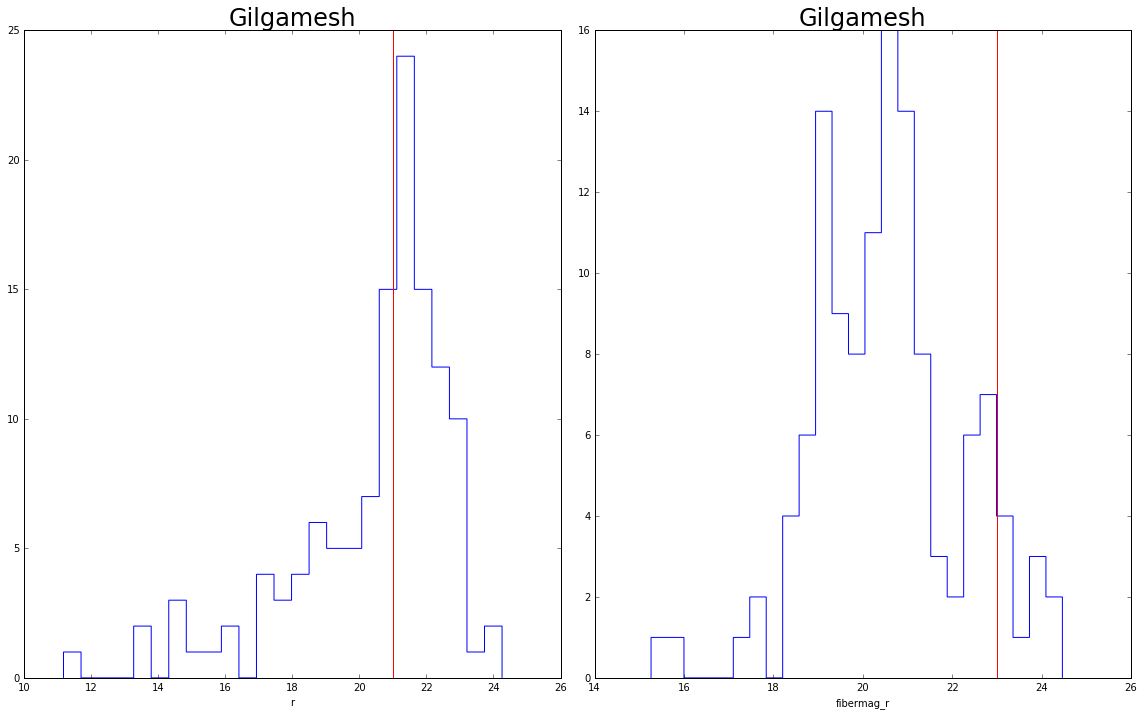

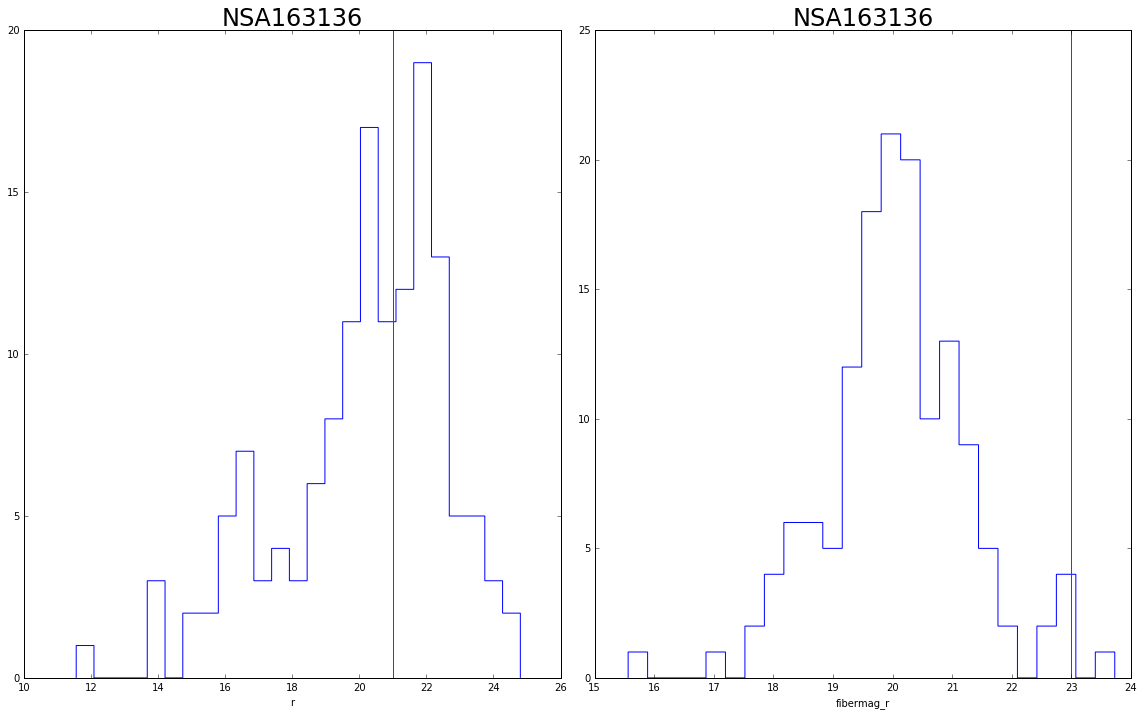

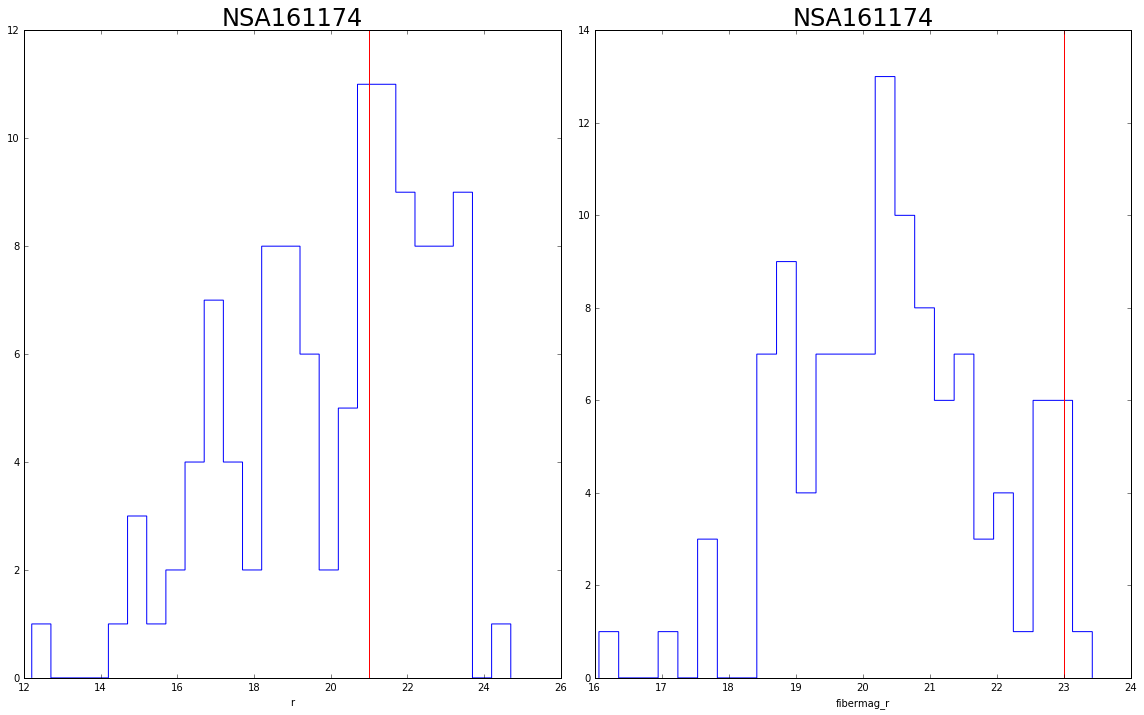

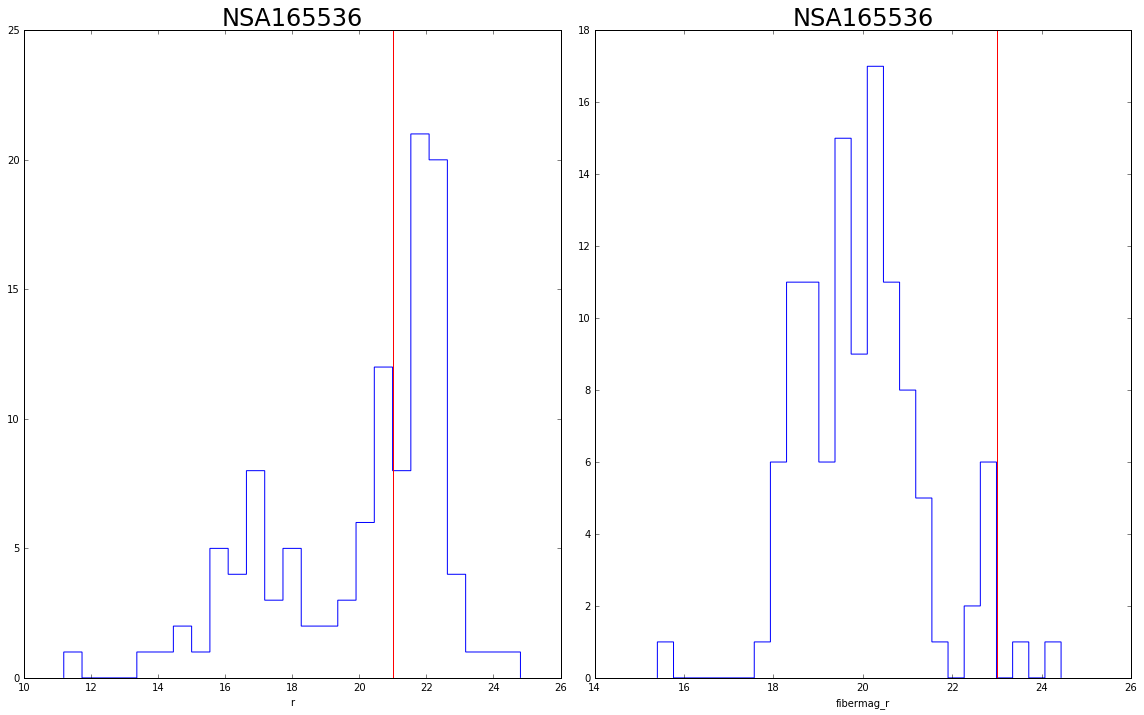

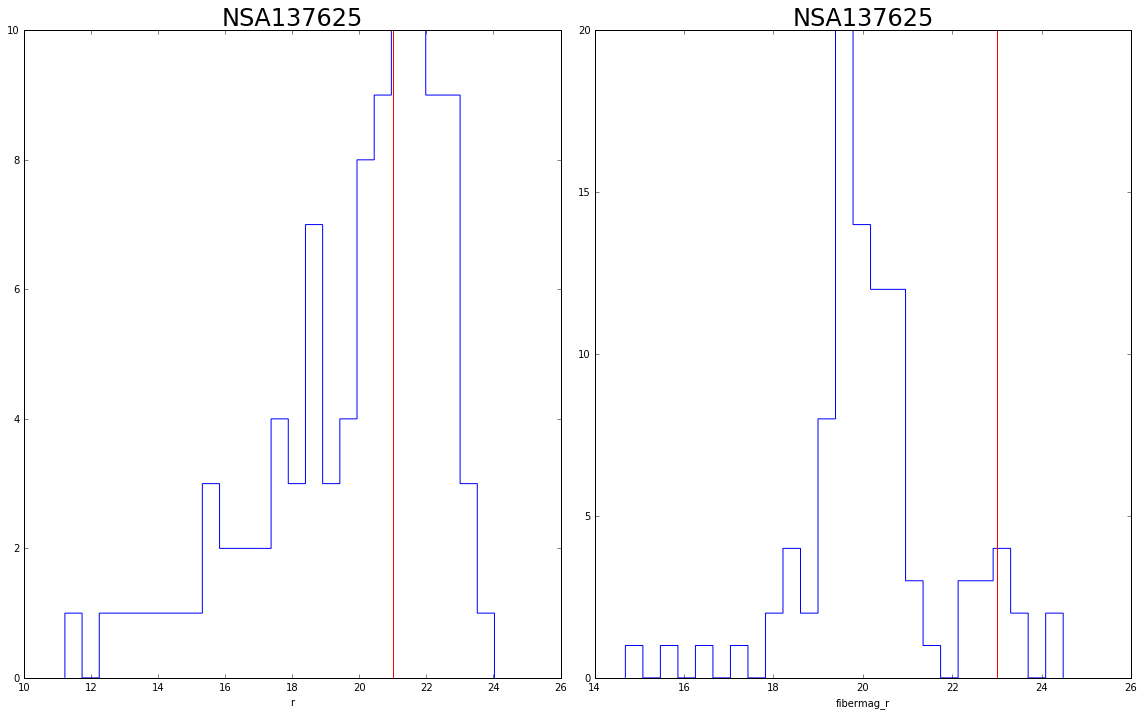

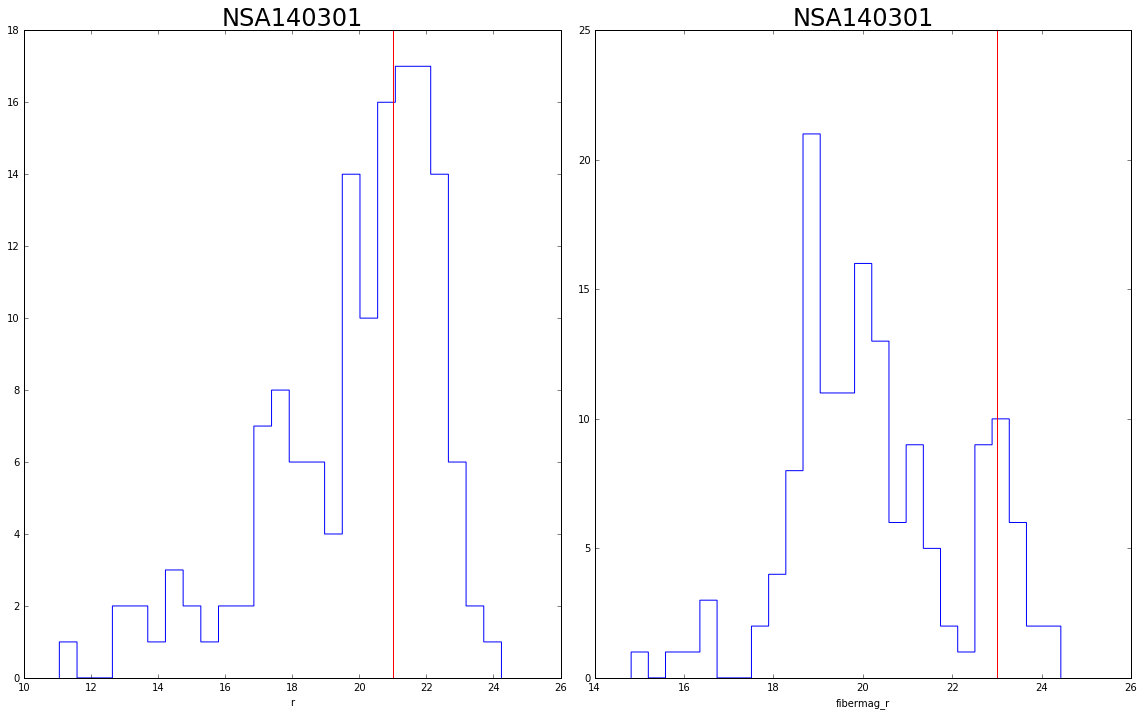

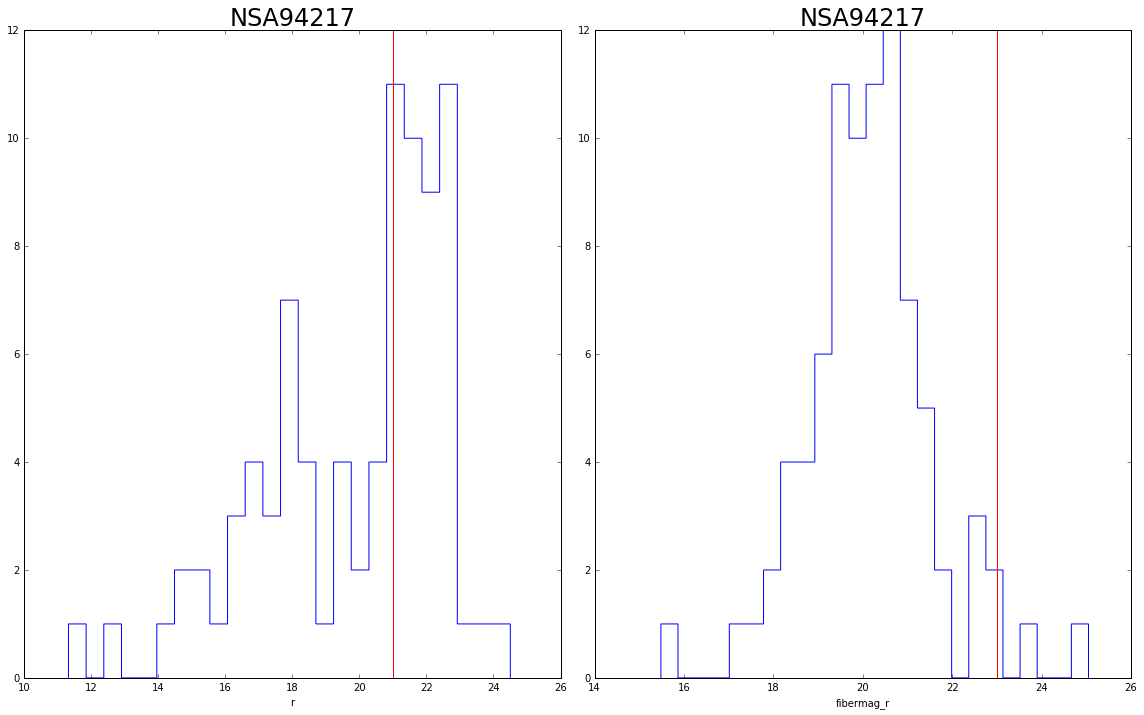

In [33]:
bins = 25
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    ranks = rankdct[h]

    plt.figure()
    
    msk = cat[p_column_for_ranking] > 0.01
    plt.subplot(1,2,1)
    ahist(cat[msk]['r'],bins=bins, histtype='step')
    plt.axvline(21,c='r')
    plt.xlabel('r')
    plt.title(h.name, fontsize=24)
    
    plt.subplot(1,2,2)
    ahist(cat[msk]['fibermag_r'],bins=bins, histtype='step')
    plt.axvline(23,c='r')
    plt.xlabel('fibermag_r')
    plt.title(h.name, fontsize=24)
    
    plt.tight_layout()

### Plot the catalogs as a whole

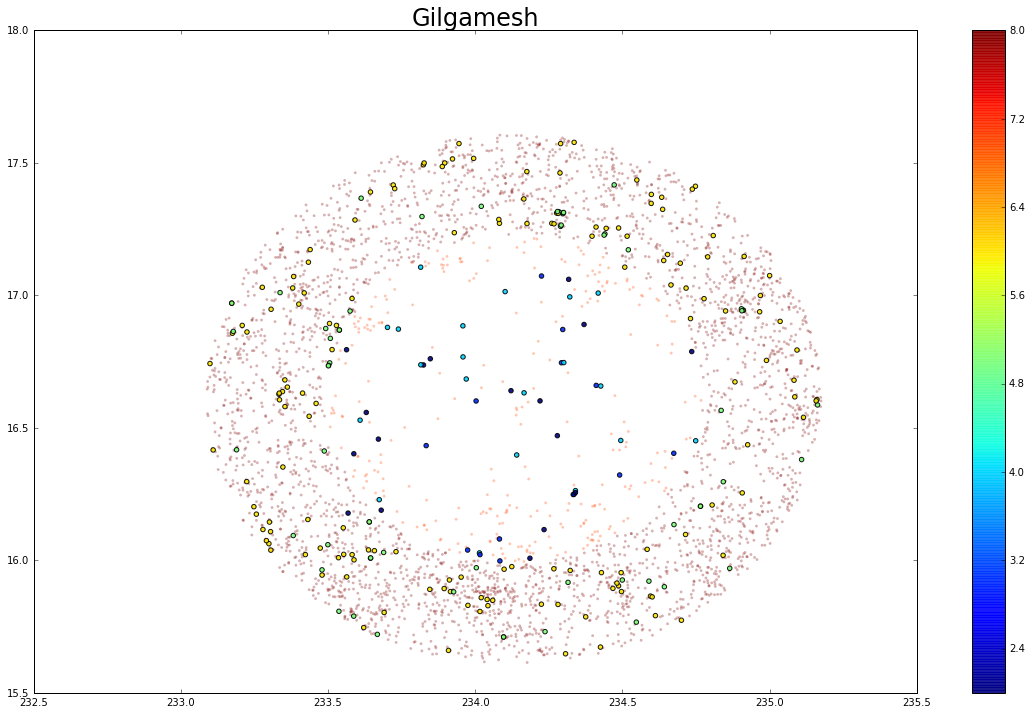

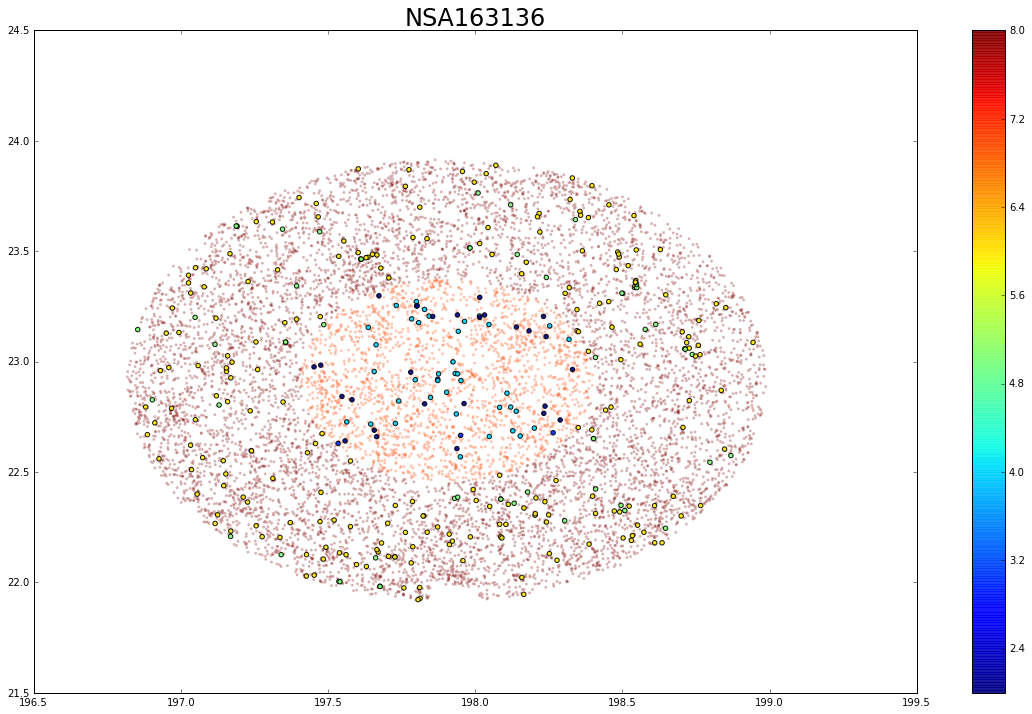

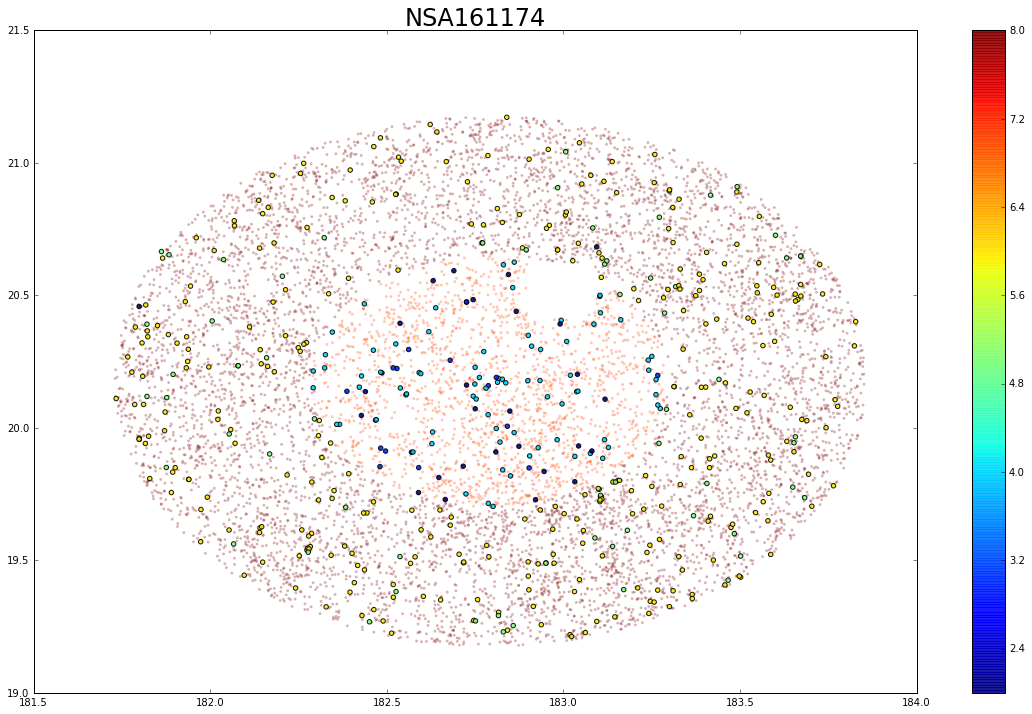

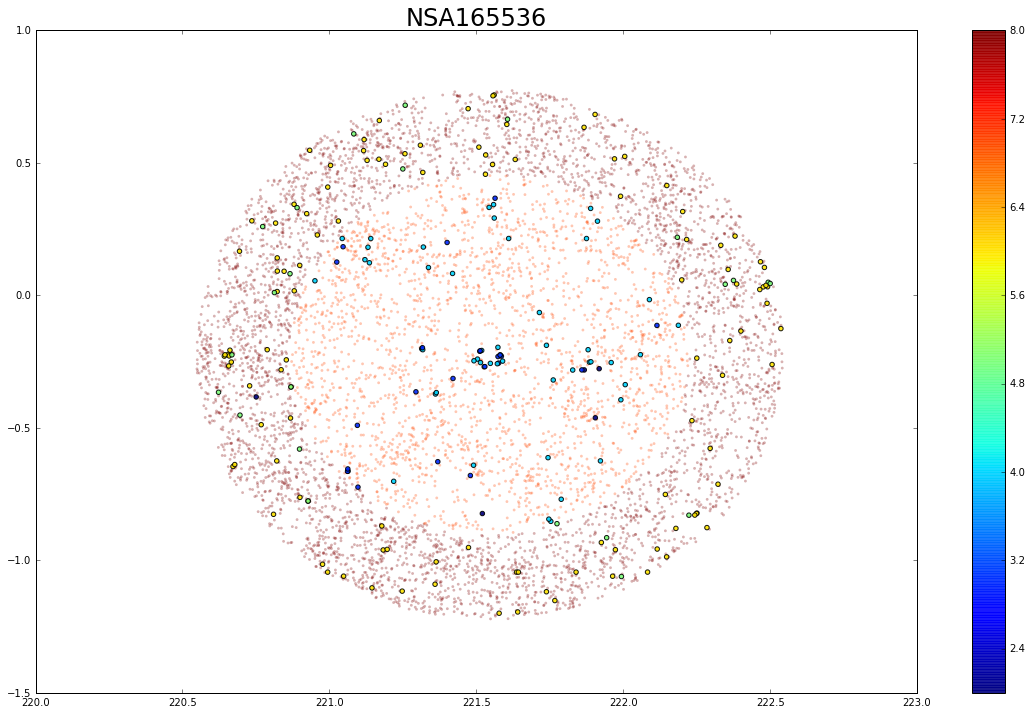

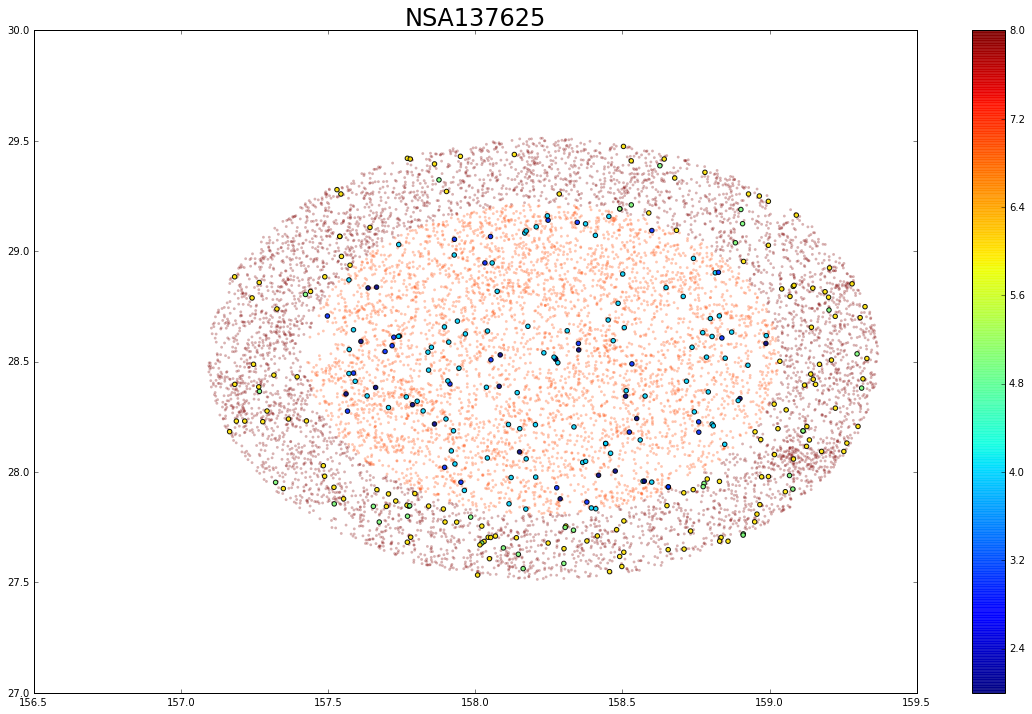

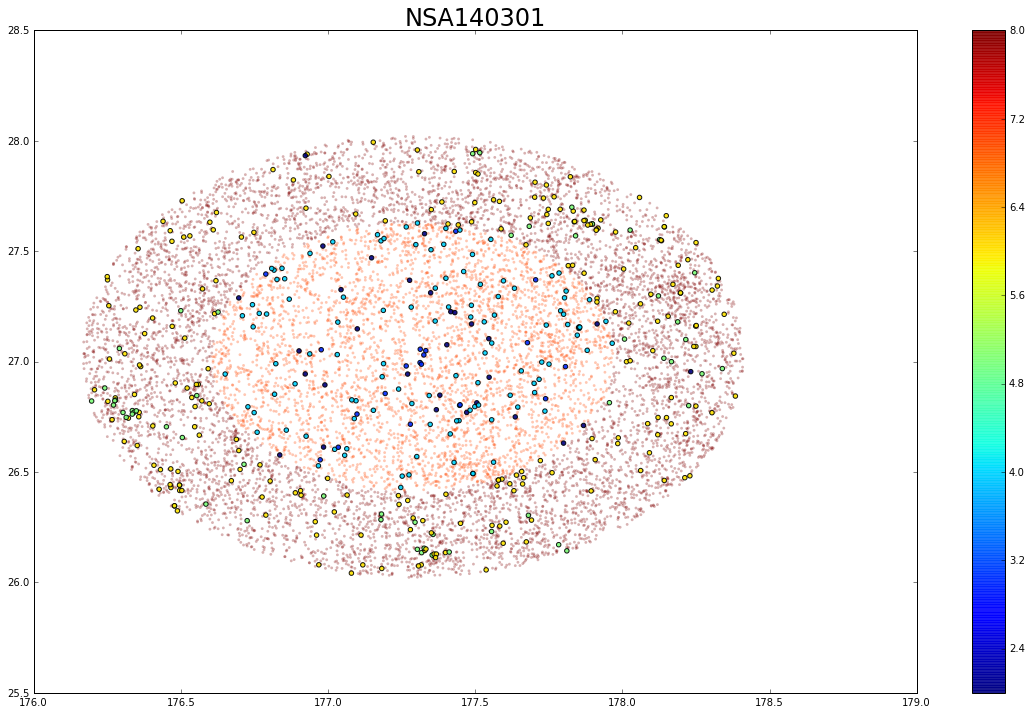

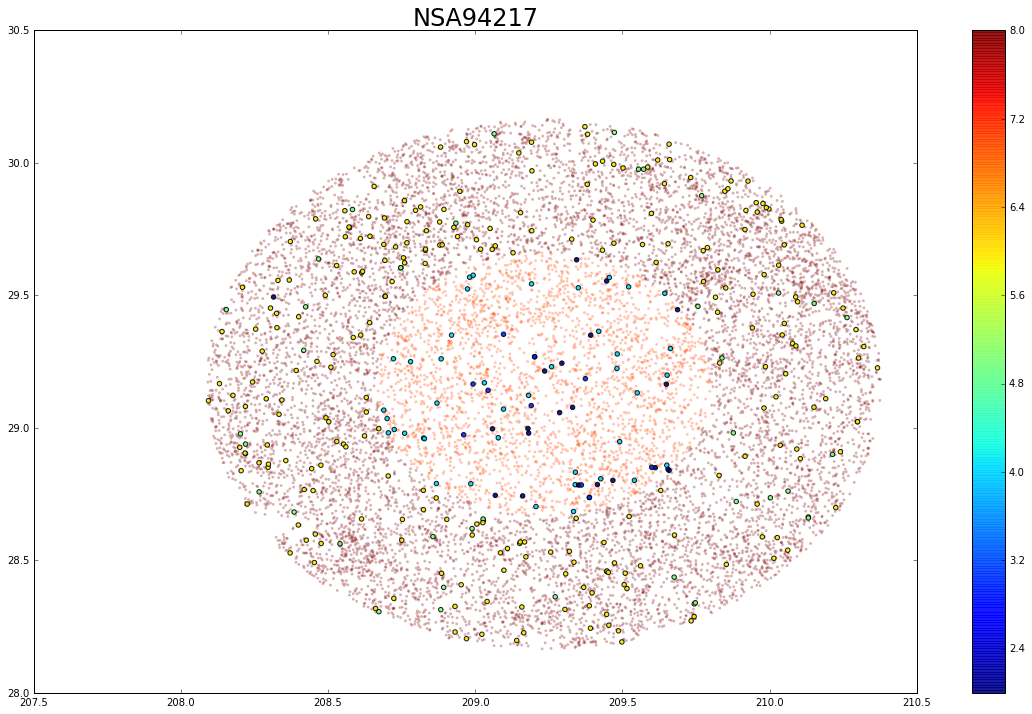

In [34]:
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    ranks = rankdct[h]

    plt.figure()
    
    msk_ml = (ranks>1)&(ranks<7)
    msk_nml = (ranks>6)
    
    plt.scatter(cat['ra'][msk_nml], cat['dec'][msk_nml], lw=0, alpha=.3, c=ranks[msk_nml],s=8, vmin=2, vmax=np.max(ranks))
    plt.scatter(cat['ra'][msk_ml], cat['dec'][msk_ml], lw=1, alpha=.9, c=ranks[msk_ml],s=20, vmin=2, vmax=np.max(ranks))
    
    plt.colorbar()
    
    
    plt.title(h.name, fontsize=24)
    
    plt.tight_layout()

# Generate catalogs 

In [37]:
generated_cats = {}
for h in hosts_to_target:
    print('On host', h.name)
    sys.stdout.flush()

    cat = h.get_sdss_catalog()
    ranks = rankdct[h]
    
    fnout = 'mmthecto/{0}_mar2016.cat'.format(h.name)
    fluxfnout = fnout.replace('.cat', '.fluxstars')
    print('Going to write', fnout)
    
    msk = (cat['RHOST_ARCM']<40) & (ranks>0) & (ranks<11)
    generated_cats[h] = mmthecto.generate_catalog(h, cat[msk], ranks[msk], 
                                         repeatflux=3, removefluxdistance=(1*u.arcmin,ranks[msk]<7),
                                         fnout=fnout, fluxfnout=fluxfnout)

On host Gilgamesh
Going to write mmthecto/Gilgamesh_mar2016.cat
Including 675 targets
Found 221 Flux stars
Removing 4 Flux stars too close to program stars
Found 403 guide stars
On host NSA163136
Going to write mmthecto/NSA163136_mar2016.cat
Including 4843 targets
Found 102 Flux stars
Removing 3 Flux stars too close to program stars
Found 220 guide stars
On host NSA161174
Going to write mmthecto/NSA161174_mar2016.cat
Including 4160 targets
Found 70 Flux stars
Removing 6 Flux stars too close to program stars
Found 192 guide stars
On host NSA165536
Going to write mmthecto/NSA165536_mar2016.cat
Including 2404 targets
Found 203 Flux stars
Removing 2 Flux stars too close to program stars
Found 437 guide stars
On host NSA137625
Going to write mmthecto/NSA137625_mar2016.cat
Including 4303 targets
Found 57 Flux stars
Removing 4 Flux stars too close to program stars
Found 269 guide stars
On host NSA140301
Going to write mmthecto/NSA140301_mar2016.cat
Including 5145 targets
Found 54 Flux stars
R

### check flux and guide stars to make sure there are enough

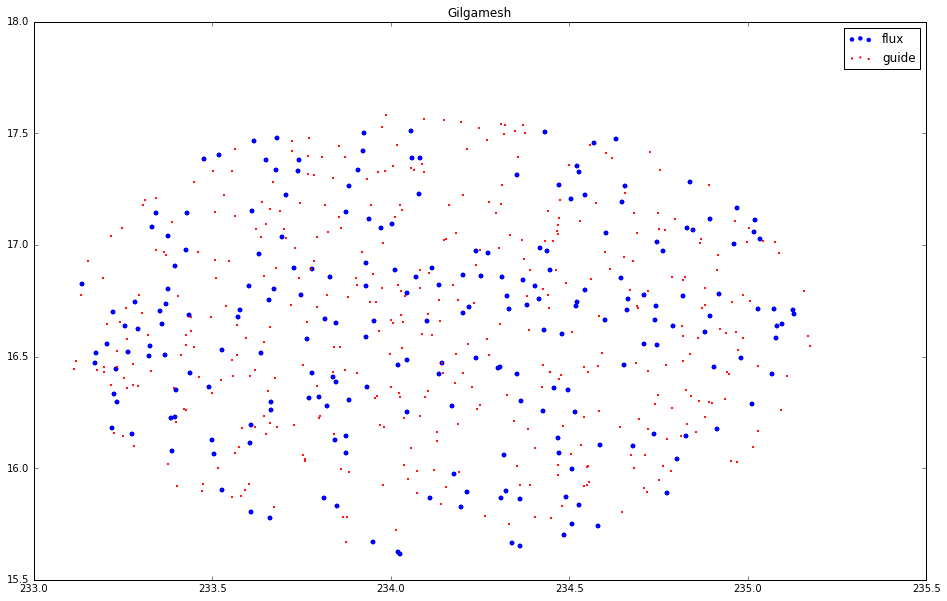

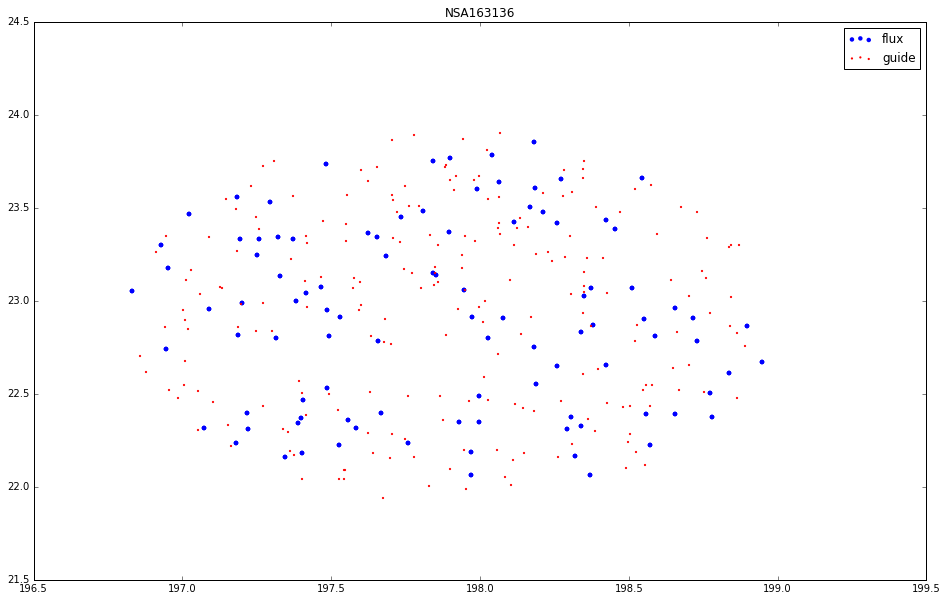

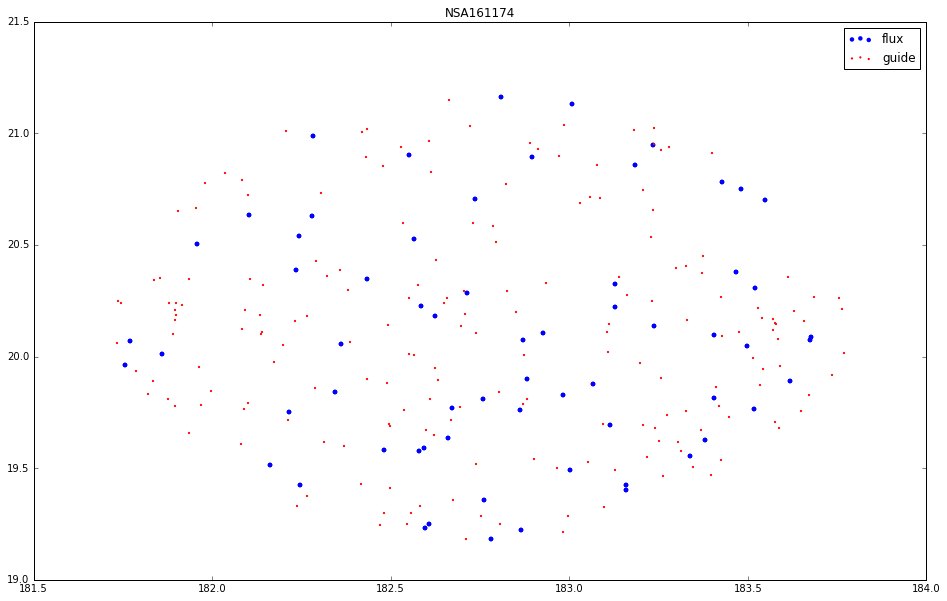

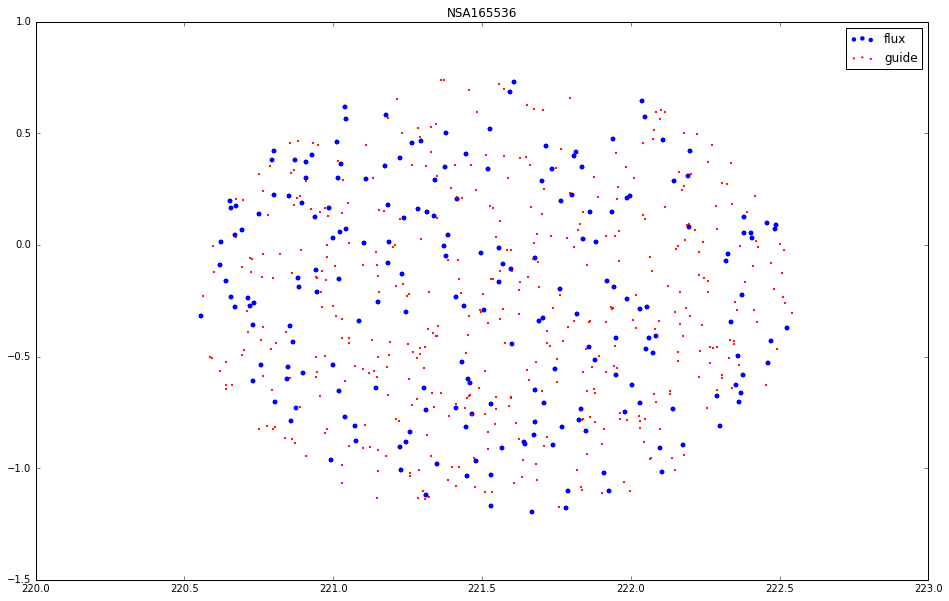

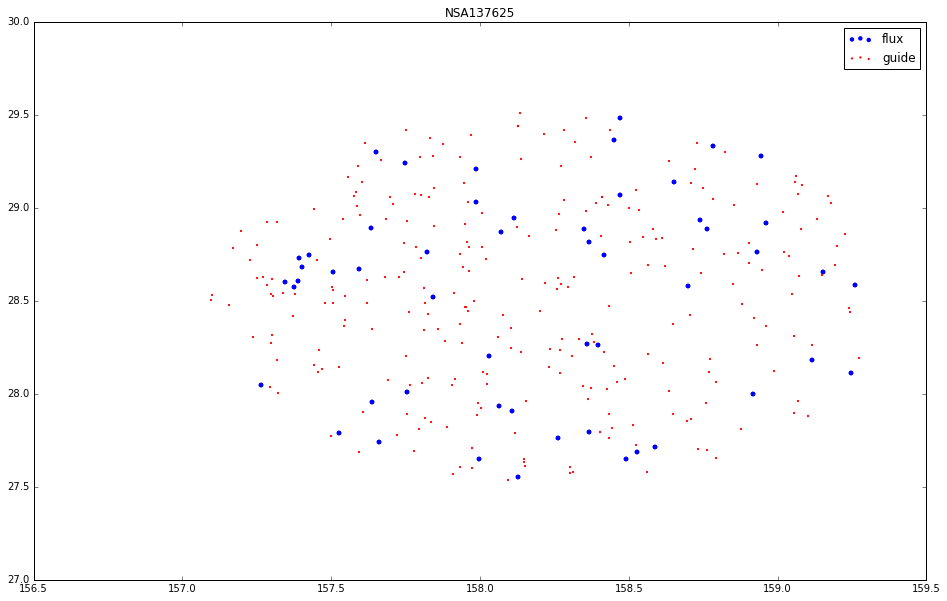

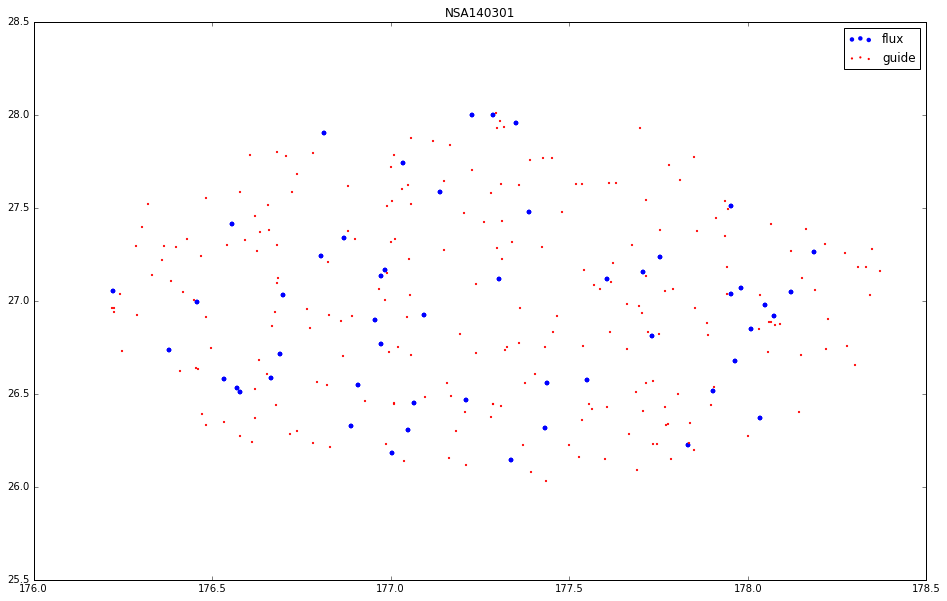

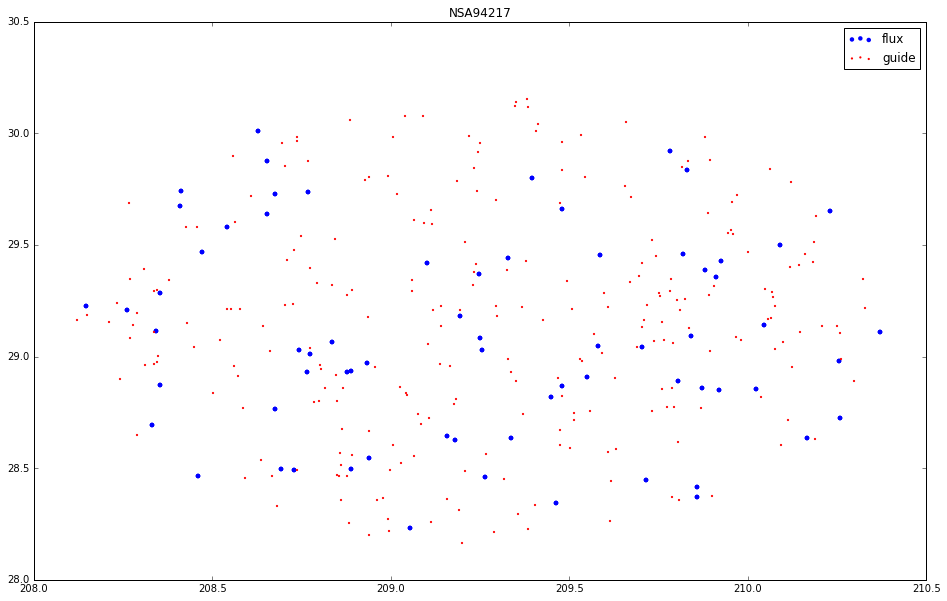

In [38]:
for h in hosts_to_target:
    gcat = generated_cats[h]
    fmsk = gcat['rank']=='1'
    gmsk = gcat['type'] == 'guide'
    
    plt.figure()
    plt.title(h.name)
    plt.scatter(gcat['ra'][fmsk], gcat['dec'][fmsk],lw=0, label='flux')
    plt.scatter(gcat['ra'][gmsk], gcat['dec'][gmsk], c='r',s=5, lw=0, label='guide')
    plt.legend()

# Object inspection

## Inspect some objects in the input/ranked catalog 

In [39]:
# h = [h for h in hosts_to_target if h.name=='Gilgamesh']
# assert len(h)==1
#h = h[0]
h = hosts_to_target[0]
print(h.name)

cat = h.get_sdss_catalog()
ranks = rankdct[h]

fibmag = cat['fibermag_r']
mag = cat['r']

msk = (ranks==7)

targeting.sampled_imagelist(cat[msk], None, 200, names=['r={0[0]}_fm={0[1]}_m={0[2]}'.format(t) for t in zip(ranks[msk],fibmag[msk],mag[msk])])

np.sum(msk)

Gilgamesh


286

In [20]:
# this is meant for *every* host
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    ranks = rankdct[h]

    fibmag = cat['fibermag_r']
    msk = (ranks==2)

    targeting.sampled_imagelist(cat[msk], None, 200, names=['r={0[0]}_fm={0[1]}'.format(t) for t in zip(ranks[msk],fibmag[msk])])
    print(np.sum(msk), 'for', h.name)

18 for Gilgamesh
26 for NSA163136
30 for NSA161174
5 for NSA165536
20 for NSA137625
30 for NSA140301
22 for NSA94217


### This allows logging of two categories

In [37]:
answers = {}
totals = {}
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    ranks = rankdct[h]

    fibmag = cat['fibermag_r']

    msk_rank = (ranks==3)|(ranks==5)
    msk_phot = (cat['r'] < 21.5) & (cat['fibermag_r']<23) & (cat['phot_sg']=='GALAXY')
    msk1 = msk_rank&msk_phot
    msk2 = msk_rank&~msk_phot

    targeting.sampled_imagelist(cat[msk1], None, np.sum(msk1), names=['r={0[0]}_fm={0[1]}'.format(t) for t in zip(ranks[msk1],fibmag[msk1])])
    targeting.sampled_imagelist(cat[msk2], None, np.sum(msk2), names=['r={0[0]}_fm={0[1]}'.format(t) for t in zip(ranks[msk2],fibmag[msk2])])

    res = raw_input('Total of {} in 1 and {} in 2 for {}. Enter your counts as "#,#": '.format(np.sum(msk1), np.sum(msk2), h.name))
    answers[h.name] =  res
    totals[h.name] = (np.sum(msk1), np.sum(msk2))
    
answers = {nm: [int(val) for val in answers[nm].split(',')] for nm in answers}
fracs = {nm:(answers[nm][0]/totals[nm][0], answers[nm][1]/totals[nm][1]) for nm in answers}
fracs

Total of 23 in 1 and 45 in 2 for Gilgamesh. Enter your counts as "#,#": 2,4
Total of 30 in 1 and 25 in 2 for NSA163136. Enter your counts as "#,#": 2,5
Total of 58 in 1 and 33 in 2 for NSA161174. Enter your counts as "#,#": 6, 4
Total of 22 in 1 and 23 in 2 for NSA165536. Enter your counts as "#,#": 6,5
Total of 29 in 1 and 32 in 2 for NSA137625. Enter your counts as "#,#": 0,3
Total of 38 in 1 and 41 in 2 for NSA140301. Enter your counts as "#,#": 2,6
Total of 25 in 1 and 25 in 2 for NSA94217. Enter your counts as "#,#": 4,3


{(0.0, 0.09375),
 (0.052631578947368418, 0.14634146341463414),
 (0.066666666666666666, 0.20000000000000001),
 (0.086956521739130432, 0.088888888888888892),
 (0.10344827586206896, 0.12121212121212122),
 (0.16, 0.12),
 (0.27272727272727271, 0.21739130434782608)}

In [40]:
answers = {}
totals = {}
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    ranks = rankdct[h]

    fibmag = cat['fibermag_r']

    msk_rank = (ranks==3)|(ranks==5)
    msk_phot = (cat['r'] < 21.5) & (cat['fibermag_r']<23) & (cat['phot_sg']=='GALAXY')
    msk1 = msk_rank&msk_phot
    msk2 = msk_rank&~msk_phot

    targeting.sampled_imagelist(cat[msk1], None, np.sum(msk1), names=['r={0[0]}_fm={0[1]}'.format(t) for t in zip(ranks[msk1],fibmag[msk1])])
    targeting.sampled_imagelist(cat[msk2], None, np.sum(msk2), names=['r={0[0]}_fm={0[1]}'.format(t) for t in zip(ranks[msk2],fibmag[msk2])])

    res = raw_input('Total of {} in 1 and {} in 2 for {}. Enter your counts as "#,#": '.format(np.sum(msk1), np.sum(msk2), h.name))
    answers[h.name] =  res
    totals[h.name] = (np.sum(msk1), np.sum(msk2))
    
answers = {nm: [int(val) for val in answers[nm].split(',')] for nm in answers}
fracs = {nm:(answers[nm][0]/totals[nm][0], answers[nm][1]/totals[nm][1]) for nm in answers}
fracs

Total of 23 in 1 and 45 in 2 for Gilgamesh. Enter your counts as "#,#": 2,4
Total of 30 in 1 and 25 in 2 for NSA163136. Enter your counts as "#,#": 2,5
Total of 58 in 1 and 33 in 2 for NSA161174. Enter your counts as "#,#": 6,4
Total of 22 in 1 and 23 in 2 for NSA165536. Enter your counts as "#,#": 6,5
Total of 29 in 1 and 32 in 2 for NSA137625. Enter your counts as "#,#": 0,3
Total of 38 in 1 and 41 in 2 for NSA140301. Enter your counts as "#,#": 2,6
Total of 25 in 1 and 25 in 2 for NSA94217. Enter your counts as "#,#": 4,3


{'Gilgamesh': (0.086956521739130432, 0.088888888888888892),
 'NSA137625': (0.0, 0.09375),
 'NSA140301': (0.052631578947368418, 0.14634146341463414),
 'NSA161174': (0.10344827586206896, 0.12121212121212122),
 'NSA163136': (0.066666666666666666, 0.20000000000000001),
 'NSA165536': (0.27272727272727271, 0.21739130434782608),
 'NSA94217': (0.16, 0.12)}

RESULTS from running the above cell with category 1 being "good phot" and high ML, while 2 is "bad phot" and high ML.  Fractions are how many 

> Total of 23 in 1 and 45 in 2 for Gilgamesh. Enter your counts as "#,#": 2,4

> Total of 30 in 1 and 25 in 2 for NSA163136. Enter your counts as "#,#": 2,5

> Total of 58 in 1 and 33 in 2 for NSA161174. Enter your counts as "#,#": 6, 4

> Total of 22 in 1 and 23 in 2 for NSA165536. Enter your counts as "#,#": 6,5

> Total of 29 in 1 and 32 in 2 for NSA137625. Enter your counts as "#,#": 0,3

> Total of 38 in 1 and 41 in 2 for NSA140301. Enter your counts as "#,#": 2,6

> Total of 25 in 1 and 25 in 2 for NSA94217. Enter your counts as "#,#": 4,3

> {'Gilgamesh': (0.086956521739130432, 0.088888888888888892),
 'NSA137625': (0.0, 0.09375),
 'NSA140301': (0.052631578947368418, 0.14634146341463414),
 'NSA161174': (0.10344827586206896, 0.12121212121212122),
 'NSA163136': (0.066666666666666666, 0.20000000000000001),
 'NSA165536': (0.27272727272727271, 0.21739130434782608),
 'NSA94217': (0.16, 0.12)}

## Inspect an output  catalog of a particular host

In [ ]:
h = hosts_to_target[0]
h.name

In [ ]:
gcat = generated_cats[h]

ranknum = gcat['rank'].copy()
ranknum[gcat['rank']==''] = '-1'
ranknum = ranknum.astype(int)

ranknum = gcat['rank'].copy()
ranknum[gcat['rank']==''] = '-1'
ranknum = ranknum.astype(int)
{r: np.sum(r==ranknum) for r in set(ranknum)}

In [ ]:
msk = (ranknum>1)&(ranknum<3)  # special targets
msk = ranknum==1 # flux stars

gcatm = gcat[msk]
targeting.sampled_imagelist(gcatm[np.argsort(gcatm['ra'])], None, 200, names=gcat['rank'][msk])
len(gcatm)

## Clump searching 

In [ ]:
#identify clumps of nearby objects - note that this is slow for large sets of objects

def find_clumps(host, rankrng=(1, 10), show_in_sdss=True):
    msk = (ranknum>rankrng[0])&(ranknum<rankrng[1])  # ML targets
    gcatm = generated_cats[host][msk]

    gcatmsc = SkyCoord(gcatm['ra'], gcatm['dec'], unit=u.deg)
    seps = u.Quantity([c.separation(gcatmsc) for c in gcatmsc])

    pairs = zip(*np.where((seps>0.1*u.arcsec)&(seps<10*u.arcsec)))
    pairs = [pair for pair in pairs if pair[0]<pair[1]]

    clumps = []
    for p1, p2 in pairs:
        for clump in clumps:
            if p1 in clump:
                clump.append(p2)
                break
            elif p2 in clump:
                clump.append(p1)
                break
        else:
            clumps.append([p1, p2])
    if show_in_sdss:
        for cl in clumps:
            targeting.sampled_imagelist(gcatm[np.array(cl)], None, None, names=cl)
    return clumps

for h in hosts_to_target:
    clumps = find_clumps(h, show_in_sdss=False)
    if clumps:
        print(h.name, 'clumps:', clumps)
    else:
        print(h.name, 'is clump-less in ML targets')